In [261]:
import warnings
warnings.filterwarnings("ignore")

In [217]:
import pandas as pd 
import numpy as np
import re
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin

# Learning curve
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier

# Feature engineer 
from feature_engine.selection import DropFeatures
from feature_engine.encoding import OneHotEncoder
from feature_engine.encoding import RareLabelEncoder
from sklearn.preprocessing import OneHotEncoder as OneHotSK
from feature_engine.outliers import Winsorizer, ArbitraryOutlierCapper
from feature_engine.imputation import (AddMissingIndicator, MeanMedianImputer, CategoricalImputer)
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer, make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline, Pipeline

# Model_Selection
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV

# Load the Data

In [276]:
def load_data():
    global df
    df = pd.read_csv("Dados/train.csv",index_col=0)
    global df_pred
    df_pred = pd.read_csv("Dados/test.csv",index_col=0)
    global x
    x = df.drop('Survived',axis=1)
    global y
    y = df.Survived
    global seed
    seed = 42
    
    global x_train, x_test, y_train, y_test
    x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.3, random_state = 0)
    
    global num_var, cat_var, target
    num_var = ['Pclass','Age','SibSp','Parch','Fare','Cabin_Size']
    cat_var = ['Sex','Cabin_code','Embarked','Name_Title', 'Name_family']
    target = ['Survived']

In [3]:
load_data()

In [92]:
x_train.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
858,1,"Daly, Mr. Peter Denis",male,51.0,0,0,113055,26.5500,E17,S
53,1,"Harper, Mrs. Henry Sleeper (Myna Haxtun)",female,49.0,1,0,PC 17572,76.7292,D33,C
387,3,"Goodwin, Master. Sidney Leonard",male,1.0,5,2,CA 2144,46.9000,NaN,S
125,1,"White, Mr. Percival Wayland",male,54.0,0,1,35281,77.2875,D26,S
579,3,"Caram, Mrs. Joseph (Maria Elias)",female,NaN,1,0,2689,14.4583,NaN,C


# Functions

In [429]:
class dtype_fix(BaseEstimator,TransformerMixin):
    """ corrects dtype of all initial features"""
    
    def __init__(self, Pclass_type=None,SibSpParch_type=None):
        self.Pclass_type=Pclass_type
        self.SibSpParch_type=SibSpParch_type
        pass
    
    def fit(self, x:pd.DataFrame, y:pd.Series=None):
        return self
    
    def transform(self, x:pd.DataFrame,y:pd.Series=None):
        df=x.copy()
        try:
            if self.Pclass_type=='O':
                df['Pclass']=df['Pclass'].astype('object')
            else :
                df['Pclass']=df['Pclass'].astype('int')
            if self.SibSpParch_type=='O':
                df['SibSp']=df['SibSp'].astype('object')
                df['Parch']=df['Parch'].astype('object')
            else:
                df['SibSp']=df['SibSp'].astype('int')
                df['Parch']=df['Parch'].astype('int')                
            df['Fare']=df['Fare'].astype('float')
            df['Sex']=df['Sex'].astype('object')
            df['Age']=df['Age'].astype('float')
            df['Cabin']=df['Cabin'].astype('object')
            df['Embarked']=df['Embarked'].astype('object')
        except:
            print('erro em dtype_fix')
        return df


def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    """
    if axes is None:
        _, axes = plt.subplots(1, figsize=(20, 10))

    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes, scoring='accuracy',
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes.grid()
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes.legend(loc="best")

    # Plot n_samples vs fit_times
   # axes[1].grid()
   # axes[1].plot(train_sizes, fit_times_mean, 'o-')
   # axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
   #                      fit_times_mean + fit_times_std, alpha=0.1)
   # axes[1].set_xlabel("Training examples")
   # axes[1].set_ylabel("fit_times")
   # axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
  #  axes[2].grid()
  #  axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
  #  axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
 #                      test_scores_mean + test_scores_std, alpha=0.1)
  #  axes[2].set_xlabel("fit_times")
  #  axes[2].set_ylabel("Score")
  #  axes[2].set_title("Performance of the model")
    print('train_scores_mean: ',train_scores_mean[-1], '\ntest_scores_mean',test_scores_mean[-1])

    return plt

def get_cross_score(pipe,cv=5):
    score = cross_val_score(pipe, x_train, y_train, cv=cv, scoring='accuracy')
    print(f'accuracy of {np.round(score.mean(),4)} and standard deviation of {np.round(score.std(),4)}')
    
def make_sub(pipe,subname):
    pipe.fit(x,y)
    pred = pipe.predict(df_pred)
    data = {'PassengerId': df_pred.index,
                 'Survived': pred}
    sub1 = pd.DataFrame(data)
    sub1.to_csv('Predições/Experiments_nb/' +subname+'.csv',header=True, index=False)

# 1. Baseline

In [6]:
x_train.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
858,1,"Daly, Mr. Peter Denis",male,51.0,0,0,113055,26.5500,E17,S
53,1,"Harper, Mrs. Henry Sleeper (Myna Haxtun)",female,49.0,1,0,PC 17572,76.7292,D33,C
387,3,"Goodwin, Master. Sidney Leonard",male,1.0,5,2,CA 2144,46.9000,NaN,S
125,1,"White, Mr. Percival Wayland",male,54.0,0,1,35281,77.2875,D26,S
579,3,"Caram, Mrs. Joseph (Maria Elias)",female,NaN,1,0,2689,14.4583,NaN,C


In [281]:
# baseline simple pipeline
pipe_base = make_pipeline(
                        MeanMedianImputer(imputation_method='mean', variables=['Age']),
                        DropFeatures(features_to_drop=['Name','Sex','Ticket','Cabin','Embarked']),
                        RandomForestClassifier(random_state=0))
get_cross_score(pipe_base,5)

accuracy of 0.6565 and standard deviation of 0.0223


In [353]:
# baseline simple pipeline
pipe_base = make_pipeline(DropFeatures(features_to_drop=['Name','Sex','Ticket','Cabin','Embarked']),
                          SimpleImputer(missing_values=np.nan, strategy='mean'),
                          RandomForestClassifier(random_state=0))
get_cross_score(pipe_base,5)

accuracy of 0.6565 and standard deviation of 0.0223


So we have our baseline model and score now.

set_config(display='diagram') shows pipelines structures in HTML

In [175]:
from sklearn import set_config

set_config(display='diagram')
pipe_base

Pipeline(steps=[('dropfeatures',
                 DropFeatures(features_to_drop=['Name', 'Sex', 'Ticket',
                                                'Cabin', 'Embarked'])),
                ('simpleimputer', SimpleImputer()),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=0))])

# 2. Feature Engineer

## Numeric Varibles

## 2.1 "Age"

There's only one thing to be done in Age: impute missing values. Let's check how each imputing strategy behaves.

In [10]:
# baseline simple pipeline
pipe_age = make_pipeline(DropFeatures(features_to_drop=['Name','Sex','Ticket','Cabin','Embarked']),
                          SimpleImputer(missing_values=np.nan, strategy='median'),
                          RandomForestClassifier(random_state=0))
get_cross_score(pipe_age,5)

accuracy of 0.6549 and standard deviation of 0.0084


Imputing with median lowers very slightly the acc but also lowers the OOF std.

In [11]:
# baseline simple pipeline
pipe_age2 = make_pipeline(DropFeatures(features_to_drop=['Name','Sex','Ticket','Cabin','Embarked']),
                          SimpleImputer(missing_values=np.nan, strategy='mean', add_indicator=True),
                          RandomForestClassifier(random_state=0))
get_cross_score(pipe_age2,5)

accuracy of 0.6564 and standard deviation of 0.0249


Add a missing indicator doesn't help either.

Sklearn SimpleImputer imputes each feature with it's mean, meadian or mode. We can create a custom imputer to impute the mean of more specific groups than just the whole feature. 

In [49]:
print('age mean: ', x_train['Age'].mean())
print('male age mean: ', x_train[x_train['Sex']=='male']['Age'].mean())
print('female age mean: ', x_train[x_train['Sex']=='female']['Age'].mean())

print('Pclass 1 age mean: ', x_train[x_train['Pclass']==1]['Age'].mean())
print('Pclass 2 age mean: ', x_train[x_train['Pclass']==2]['Age'].mean())
print('Pclass 3 age mean: ', x_train[x_train['Pclass']==3]['Age'].mean())

age mean:  29.915338645418327
male age mean:  30.728593272171253
female age mean:  28.395714285714284
Pclass 1 age mean:  38.15382352941177
Pclass 2 age mean:  29.462936507936508
Pclass 3 age mean:  25.484375


In the following example we create a custom imputer to impute missing values for age based on the mean of 2 grouped features. Unless we discretize the numerical features, we're going to have to pick categorical features to group by. Pclass and sex both have big predictive pontential and diferent means for each class, so it seems logical to group by those two.

In [12]:
class AgeGroupImputer(BaseEstimator, TransformerMixin):
    """Impute missing values with the mean of the group"""
    def __init__(self,group:list=['Pclass','Sex']):
        super().__init__()
        self.group = group
        self.age_means_ = {}

    def fit(self, x:pd.DataFrame, y:pd.Series=None):
        self.age_means_ = x.groupby(self.group).Age.mean()
        return self

    def transform(self, x:pd.DataFrame, y:pd.Series=None):
        x = x.copy()
        for key, value in self.age_means_.items():
            x.loc[((np.isnan(x["Age"])) & (x[self.group[0]] == key[0]) & (x[self.group[1]] == key[1])), 'Age'] = value

        return x

In [174]:
gp = AgeGroupImputer(group=['Pclass','Sex'])
x_age = gp.fit_transform(x_train)
gp.age_means_

Pclass  Sex   
1       female    34.934426
        male      40.772267
2       female    29.405660
        male      29.504521
3       female    20.979508
        male      27.019553
Name: Age, dtype: float64

In [173]:
pipe_age = make_pipeline(AgeGroupImputer(group=['Pclass','Sex']),
                        DropFeatures(features_to_drop=['Name','Sex','Ticket','Cabin','Embarked']),
                        RandomForestClassifier(random_state=0))
get_cross_score(pipe_age,5)
pipe_age

accuracy of 0.6917 and standard deviation of 0.026


Pipeline(steps=[('agegroupimputer', AgeGroupImputer()),
                ('dropfeatures',
                 DropFeatures(features_to_drop=['Name', 'Sex', 'Ticket',
                                                'Cabin', 'Embarked'])),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=0))])

There was a improvement of almost 4% in acc by imputing the values for Age by Pclass and Sex goupby. This is our new baseline.

## 2.2 "Fare"

Tree algorithms usually doesn't benefit much from scaling numerical features but let's try it anyway.

In [15]:
pipe_fare = make_pipeline(AgeGroupImputer(group=['Pclass','Sex']),
                          DropFeatures(features_to_drop=['Name','Sex','Ticket','Cabin','Embarked']),
                          MinMaxScaler(),
                          RandomForestClassifier(random_state=0))
get_cross_score(pipe_fare,5)

accuracy of 0.6885 and standard deviation of 0.0278


Acc decreased by scaling features.

## Categorical Variables

# 2.3 "Name"

Extract Title and Family name from feature "Name"

In [30]:
class get_feat_name(BaseEstimator, TransformerMixin):
    """create column with family name  and title of each passenger"""
    def __init__(self, title:bool=True,family:bool=True):
        self.title = title
        self.family = family
        pass
    
    def fit(self, x:pd.DataFrame, y:pd.Series=None):
        return self
    
    def transform(self, x:pd.DataFrame, y:pd.Series=None):
        df = x.copy()
        try:
            if self.title:
                df['Name_title'] = df['Name'].apply(lambda x: x.split(",")[1]).apply(lambda x: x.split(".")[0])
            if self.family:
                df['Name_family'] = df['Name'].apply(lambda x: x.split(",")[0])
            
        except:
            print('erro em get_name')
        return df

x_train_ = get_feat_name(family=True,title=True).fit_transform(x_train)
x_train_.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Name_title,Name_family
PassengerId,,,,,,,,,,,,
858,1,"Daly, Mr. Peter Denis",male,51.0,0,0,113055,26.5500,E17,S,Mr,Daly
53,1,"Harper, Mrs. Henry Sleeper (Myna Haxtun)",female,49.0,1,0,PC 17572,76.7292,D33,C,Mrs,Harper
387,3,"Goodwin, Master. Sidney Leonard",male,1.0,5,2,CA 2144,46.9000,NaN,S,Master,Goodwin
125,1,"White, Mr. Percival Wayland",male,54.0,0,1,35281,77.2875,D26,S,Mr,White
579,3,"Caram, Mrs. Joseph (Maria Elias)",female,NaN,1,0,2689,14.4583,NaN,C,Mrs,Caram


In [18]:
family_labels = pd.DataFrame(x_train_['Name_family'].value_counts())
print(f'Amount of unique labels in family name:', family_labels.shape[0])
print(f'\n Family names with more than 3 occurrences:')
family_labels[family_labels["Name_family"]>3]

Amount of unique labels in family name: 502

 Family names with more than 3 occurrences:


,Name_family
Sage,7
Andersson,7
Brown,4
Rice,4
Carter,4
Lefebre,4
Ford,4
Goodwin,4


"Name_family" is now a categorical feature and we'll have to encode it so the model can use it.

In [19]:
title_labels = pd.DataFrame(x_train_['Name_title'].value_counts())
print(f'Amount of unique labels in title:', title_labels.shape[0])
print(f'\nTitles with more than 3 occurrences:')
title_labels[title_labels["Name_title"]>3]

Amount of unique labels in title: 14

Titles with more than 3 occurrences:


,Name_title
Mr,367
Miss,121
Mrs,88
Master,31


### 2.3.1 Scikit-Learn Approach

If we're to use Scikit Learn approach instead of feature-engine (it returns pd.DataFrame instead of np.array and let's you select which columns each transformer will be applied by name), we're going to need to develop a custom transformer to deal with rare labels. 

In [25]:
class fix_rare_labels(BaseEstimator,TransformerMixin):
    """transforms rare labels values in 'Rare'.
      Make sure to use the same order calling "variables" for train and predict"""
    
    def __init__(self,variables:list,threshold:list):
        super().__init__()
        self.threshold = threshold  #frequency threshold
        #self.freq_list= []
        self.variables = variables
        self.freq_labels = []
        pass
    
    def fit(self, x:pd.DataFrame, y:pd.Series=None):
        """ Saves in memory a list of which each item is a list 
            of frequent labels for a initializes variable """

        x = x.copy()
        try:
            # for each variable
            for c,var in enumerate(self.variables):
                # dic with keys for unique labels and occurrence count of said label for value 
                label_occurrence = x[var].value_counts().to_dict()
                # initialize an empty list for the frequent labels of var
                frequent_by_feat = []
                # loop for each unique label of var
                for (key,value) in label_occurrence.items():
                    # if the label has more than threshold occurrences
                    if value > self.threshold[c]:
                        # append this label to the list of frequent labels of var
                        frequent_by_feat.append(key)
                # append the list of frequent labels of this feature to a list. 
                # "freq_labels" is a list of wich each item is a list of frequent labels for a variable
                    # exp.: the first item of "freq_labels" is a list of frequent labels 
                    # for the first var from self.variables and so on
                self.freq_labels.append(frequent_by_feat)
                
        except Exception as err:
            print(err)
            print('error in fix_rare_labels fit')
        return self
    
    def transform(self, x:pd.DataFrame, y:pd.Series=None):
        """ replaces rare labels for the str "Rare" """
        x = x.copy()
        try: 
            # loop for each feature
            for c,var in enumerate(self.variables):
                # dataframe with unique labels as index and occurrence count of said label as values for this loop's feat
                label_occurrence = pd.DataFrame(x[var].value_counts())
                # loop for each unique label
                for unique_label in label_occurrence.index:
                    # we need a df with value True of False if the label from index is in list of frequent labels 
                    # if label is in list of frequent labels of his feature
                    if unique_label in self.freq_labels[c]:
                        # replace the occurrence count with "False"
                        label_occurrence.loc[unique_label]= False
                    else:
                        # replace the occurrence count with "True"
                        label_occurrence.loc[unique_label]= True
                # transform list to boolean type
                label_occurrence_bool = (label_occurrence.iloc[:,0]).astype(bool)
                # replaces rare labels for the string "Rare"
                x[var] = x[var].mask(x[var].map(label_occurrence_bool),"Rare")
        except Exception as err:
            print('error in fix_rare_labels transform') 
            print(err)
        return x

In [26]:
fl = fix_rare_labels(variables=['Name_family', 'Name_title'], threshold=[3,10])
x_rare = fl.fit_transform(x_train_)
fl.freq_labels

[['Sage',
  'Andersson',
  'Brown',
  'Rice',
  'Carter',
  'Lefebre',
  'Ford',
  'Goodwin'],
 [' Mr', ' Miss', ' Mrs', ' Master']]

The pipeline should look something like this:

In [172]:
# pipeline for extracting features
ext_pp = make_pipeline(get_feat_name(family=True, title=True))

# pipeline for categorical variables preprocessing 
cat_pp = Pipeline([
    ('Rare Encode Title and Family',fix_rare_labels(variables=['Name_family', 'Name_title'], threshold=[3,10])),
    ('OneHot', OneHotSK(handle_unknown='ignore')),])

# pipeline for numerical variables
num_pp = Pipeline([('Impute mean', SimpleImputer())])#AgeGroupImputer(group=['Pclass','Sex']))])

# ColumnTransformer to apply diferent pipelines for diferent data types
merge_ct = ColumnTransformer(
    [('Numeric Vars',num_pp, make_column_selector(dtype_exclude='object')),
     ('Categorical Vars', cat_pp, make_column_selector(dtype_include='object'))])

# final pipeline
sk_pipe_family = Pipeline([('Extract features',ext_pp),
                           ('Age NAN group impute',AgeGroupImputer(group=['Pclass','Sex'])),
                           ('Drop bad features',DropFeatures(features_to_drop=['Name','Sex','Ticket','Cabin','Embarked'])),
                           ('Preprocess', cat_pp),
                           ('RandomForest', RandomForestClassifier(random_state=0))])
get_cross_score(sk_pipe_family,cv=5)
sk_pipe_family

accuracy of 0.8042 and standard deviation of 0.0438


Pipeline(steps=[('Extract features',
                 Pipeline(steps=[('get_feat_name', get_feat_name())])),
                ('Age NAN group impute', AgeGroupImputer()),
                ('Drop bad features',
                 DropFeatures(features_to_drop=['Name', 'Sex', 'Ticket',
                                                'Cabin', 'Embarked'])),
                ('Preprocess',
                 Pipeline(steps=[('Rare Encode Title and Family',
                                  fix_rare_labels(threshold=[3, 10],
                                                  variables=['Name_family',
                                                             'Name_title'])),
                                 ('OneHot',
                                  OneHotEncoder(handle_unknown='ignore'))])),
                ('RandomForest', RandomForestClassifier(random_state=0))])

## 2.3.2 Testing Rare Labels encoding

Feature-engine transformers returns pd.DataFrame instead of np.array (as sklearn) and let's you select which columns each transformer will be applied by name. As it returns pd.DataFrame, we don't loose the feature name and can build more linear pipelines, as we select exactly where each transformation must be applied.
 
 It also has a transformer called RareLabelEncoder that deals with rare labels easily.

In [171]:
pipe_name_title = make_pipeline(
    
                        #categorical features transformations
                          get_feat_name(family=True,title=True),
                          AgeGroupImputer(group=['Pclass','Sex']),
                          DropFeatures(features_to_drop=['Name','Sex','Ticket','Cabin','Embarked']),
                          RareLabelEncoder(max_n_categories=8,tol=0,variables=['Name_family']),
                          RareLabelEncoder(max_n_categories=4,tol=0,variables=['Name_title']),
                          OneHotEncoder(variables=['Name_title','Name_family']),
                          #ColumnTransformer([('encode',OneHotSK(handle_unknown='ignore'),make_column_selector(dtype_include='object'))]),
                          SimpleImputer(), # to impute missing value of "Fare" in prediction df
                        # numerical features transformation
                          #MeanMedianImputer(imputation_method='mean', variables=['Age','Fare']),
                        # model  
                        RandomForestClassifier(random_state=0))
get_cross_score(pipe_name_title,5)
pipe_name_title
#x_train_1 = pipe_name_title.fit_transform(x_train)
#x_train_1.head()

accuracy of 0.7962 and standard deviation of 0.042


Pipeline(steps=[('get_feat_name', get_feat_name()),
                ('agegroupimputer', AgeGroupImputer()),
                ('dropfeatures',
                 DropFeatures(features_to_drop=['Name', 'Sex', 'Ticket',
                                                'Cabin', 'Embarked'])),
                ('rarelabelencoder-1',
                 RareLabelEncoder(max_n_categories=8, tol=0,
                                  variables=['Name_family'])),
                ('rarelabelencoder-2',
                 RareLabelEncoder(max_n_categories=4, tol=0,
                                  variables=['Name_title'])),
                ('onehotencoder',
                 OneHotEncoder(variables=['Name_title', 'Name_family'])),
                ('simpleimputer', SimpleImputer()),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=0))])

Let's test if we actually need rare label encoders, if it helps.

In [329]:
pipe_name_title = make_pipeline(
    
                        #categorical features transformations
                          get_feat_name(family=True,title=True),
                          AgeGroupImputer(group=['Pclass','Sex']),
                        #categorical features transformations
                          DropFeatures(features_to_drop=['Name','Sex','Ticket','Cabin','Embarked']),
                          OneHotEncoder(variables=['Name_title','Name_family']),
                        # numerical features transformation
                          MeanMedianImputer(imputation_method='mean', variables=['Fare']),
                        # model  
                        RandomForestClassifier(random_state=0))
get_cross_score(pipe_name_title,5)
pipe_name_title
#x_train_1 = pipe_name_title.fit_transform(x_train)
#x_train_1.head()

accuracy of 0.8347 and standard deviation of 0.0327


Pipeline(steps=[('get_feat_name', get_feat_name()),
                ('agegroupimputer', AgeGroupImputer()),
                ('dropfeatures',
                 DropFeatures(features_to_drop=['Name', 'Sex', 'Ticket',
                                                'Cabin', 'Embarked'])),
                ('onehotencoder',
                 OneHotEncoder(variables=['Name_title', 'Name_family'])),
                ('meanmedianimputer',
                 MeanMedianImputer(imputation_method='mean',
                                   variables=['Fare'])),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=0))])

Not encode rare labels takes longer to train but improves the perfomance. The second part looks fishy to me because Rare labels tend to cause the model to overfit since there are too few samples to be statistically significant.

Let's remove Name_family again to see it anything changes.

In [169]:
pipe_name_title2 = make_pipeline(
    
                        #categorical features transformations
                          get_feat_name(family=False,title=True),
                          AgeGroupImputer(group=['Pclass','Sex']),
                          DropFeatures(features_to_drop=['Name','Sex','Ticket','Cabin','Embarked']),
                          #RareLabelEncoder(max_n_categories=8,tol=0,variables=['Name_family']),
                          #RareLabelEncoder(max_n_categories=4,tol=0,variables=['Name_title']),
                          OneHotEncoder(variables=['Name_title']),
                          #ColumnTransformer([('encode',OneHotSK(handle_unknown='ignore'),make_column_selector(dtype_include='object'))]),
                          SimpleImputer(),
                        # numerical features transformation
                          #MeanMedianImputer(imputation_method='mean', variables=['Age','Fare']),
                        # model  
                        RandomForestClassifier(random_state=0))
get_cross_score(pipe_name_title2,5)
pipe_name_title2
#x_train_1 = pipe_name_title2.fit_transform(x_train)
#x_train_1.head()

accuracy of 0.7946 and standard deviation of 0.0354


Pipeline(steps=[('get_feat_name', get_feat_name(family=False)),
                ('agegroupimputer', AgeGroupImputer()),
                ('dropfeatures',
                 DropFeatures(features_to_drop=['Name', 'Sex', 'Ticket',
                                                'Cabin', 'Embarked'])),
                ('onehotencoder', OneHotEncoder(variables=['Name_title'])),
                ('simpleimputer', SimpleImputer()),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=0))])

The accuracy decreased by ~4%, I don't trust that family name is that predictive. Let's submit a prediction to kaggle to check if the model with acc= 0.8347 isn't overfitting.

In [84]:
pipe_name_title.fit(x,y)
title_pred = pipe_name_title.predict(df_pred)
data = {'PassengerId': df_pred.index,
         'Survived': title_pred}
sub4 = pd.DataFrame(data)
sub4.to_csv('Predições/Experiments_nb/sub4.csv',header=True, index=False)

C:\Users\ticom\anaconda3\lib\site-packages\feature_engine\encoding\one_hot.py:219: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[str(feature) + "_" + str(category)] = np.where(
C:\Users\ticom\anaconda3\lib\site-packages\feature_engine\encoding\one_hot.py:219: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[str(feature) + "_" + str(category)] = np.where(


With Name_family without rare label encoding => Leaderboard score = 0.77033

In [87]:
pipe_name_title2.fit(x,y)
title_pred = pipe_name_title2.predict(df_pred)
data = {'PassengerId': df_pred.index,
         'Survived': title_pred}
sub4 = pd.DataFrame(data)
sub4.to_csv('Predições/Experiments_nb/sub5.csv',header=True, index=False)

Without Name_family => Leaderboard score = 0.72966

In [96]:
pipe_name_title3.fit(x,y)
title_pred = pipe_name_title3.predict(df_pred)
data = {'PassengerId': df_pred.index,
         'Survived': title_pred}
sub4 = pd.DataFrame(data)
sub4.to_csv('Predições/Experiments_nb/sub6.csv',header=True, index=False)

With Name_family and Rare encoding => Leaderboard score = 0.72727

well, now i feel stupid

# 2.4 Sex

Sex needs to be binary encoded. Let's develop a "Mapper" class to make this transformation.

In [123]:
class Mapper(BaseEstimator, TransformerMixin):
    """ Encode variables with the map_dict param """
    
    def __init__(self,features:list,map_dict:dict):
        
        if not isinstance(features,list):
            raise ValueError('Features should be a list')
            
        self.features = features
        self.map_dict = map_dict
        pass
    
    def fit(self, x:pd.DataFrame ,y:pd.Series=None):
        return self
    
    def transform(self,x:pd.DataFrame):
        x = x.copy()
        
        for feature in self.features:
            x[feature] = x[feature].map(self.map_dict)
        return x


In [124]:
#dict for enconding "Sex"
sex_map = {'male':1,
           'female':0}
pipe_sex_base = make_pipeline(
    
                        #categorical features transformations
                          Mapper(features=['Sex'],map_dict = sex_map),
                          DropFeatures(features_to_drop=['Name','Ticket','Cabin','Embarked']),
                        # numerical features transformation
                          MeanMedianImputer(imputation_method='mean', variables=['Age','Fare']),
                        # model  
                        RandomForestClassifier(random_state=0))
get_cross_score(pipe_sex_base,5)
pipe_sex_base

accuracy of 0.7914 and standard deviation of 0.0401


Pipeline(steps=[('mapper',
                 Mapper(features=['Sex'], map_dict={'female': 0, 'male': 1})),
                ('dropfeatures',
                 DropFeatures(features_to_drop=['Name', 'Ticket', 'Cabin',
                                                'Embarked'])),
                ('meanmedianimputer',
                 MeanMedianImputer(imputation_method='mean',
                                   variables=['Age', 'Fare'])),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=0))])

Sex improves acc a great deal versus the baseline of 0.6565.

Let's add the Mapper on top of our current best model.

In [330]:
pipe_sex = make_pipeline(
                        #categorical features transformations
                          get_feat_name(family=True,title=True),
                          AgeGroupImputer(group=['Pclass','Sex']),
                        #categorical features transformations
                          Mapper(features=['Sex'],map_dict = sex_map),
                          DropFeatures(features_to_drop=['Name','Ticket','Cabin','Embarked']),
                          OneHotEncoder(variables=['Name_title','Name_family']),
                        # numerical features transformation
                          MeanMedianImputer(imputation_method='mean', variables=['Fare']),
                        # model  
                        RandomForestClassifier(random_state=0))

#dict for enconding "Sex"
sex_map = {'male':1,
           'female':0}

get_cross_score(pipe_sex,5)
pipe_sex

accuracy of 0.8347 and standard deviation of 0.0323


Pipeline(steps=[('get_feat_name', get_feat_name()),
                ('agegroupimputer', AgeGroupImputer()),
                ('mapper',
                 Mapper(features=['Sex'], map_dict={'female': 0, 'male': 1})),
                ('dropfeatures',
                 DropFeatures(features_to_drop=['Name', 'Ticket', 'Cabin',
                                                'Embarked'])),
                ('onehotencoder',
                 OneHotEncoder(variables=['Name_title', 'Name_family'])),
                ('meanmedianimputer',
                 MeanMedianImputer(imputation_method='mean',
                                   variables=['Fare'])),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=0))])

Adding Sex on top of Name_title doesn't change accuracy. An hipotesis is that Name_title already carries the info about sex, since "Rare" has only 16 occurences and nearly all women fall under "Miss" and "Mrs", therefore, the feature Sex doesn't reduces the cost function enough to become a node in the decision tree.

Let's check the relation between Title and Age too with a violinplot.

C:\Users\ticom\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


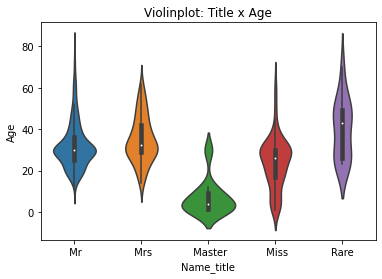

In [102]:
import seaborn as sns
import matplotlib.pyplot as plt

pipe_violin_title_age = make_pipeline(    
                        #categorical features transformations
                          get_feat_name(family=True,title=True),
                          RareLabelEncoder(max_n_categories=4,tol=0,variables=['Name_title']),
                          Mapper(features=['Sex'],map_dict=sex_map),
                          DropFeatures(features_to_drop=['Name','Ticket','Cabin','Embarked']),
                        # numerical features transformation
                          MeanMedianImputer(imputation_method='mean', variables=['Age','Fare']),)
x_train_2 = pipe_violin_title_age.fit_transform(x_train)

sns.violinplot(x_train_2['Name_title'],x_train_2['Age'])
plt.title('Violinplot: Title x Age')
plt.show()

Master has considerably lower Age mean and the interquartiles of "Mrs" and "Miss" differ too. Title carries some info about age.

# 2.5 Cabin

In [106]:
class Cabin_code(BaseEstimator, TransformerMixin):
    """Create column with first character of the first Cabin and how many cabins"""
    
    def __init__(self,code=True,size=True):
        self.code=code
        self.size=size
        pass
        
    def fit(self, x:pd.DataFrame ,y:pd.Series=None):
        return self
    
    def transform(self,x:pd.DataFrame,y:pd.Series=None):
        x = x.copy()
        try:
            if self.code:
                x['Cabin_code'] = x['Cabin'].apply(lambda x: x[0])
            if self.size:
                x['Cabin_Size'] = x['Cabin'].apply(lambda x: len(x.split(" ")))
        except Exception as err:
            print('erro no Cabin_code')
            print(err)
        return x

In [126]:
pipe_cabin_base = make_pipeline(
                        # extract features
                          CategoricalImputer(variables='Cabin',fill_value='?'),
                          Cabin_code(code=True,size=True),
                        #categorical features transformations
                          DropFeatures(features_to_drop=['Name','Ticket','Cabin','Embarked','Sex']),
                          OneHotEncoder(variables=['Cabin_code']),
                        # numerical features transformation
                          MeanMedianImputer(imputation_method='mean', variables=['Age','Fare']),
                        # model  
                        RandomForestClassifier(random_state=0))
get_cross_score(pipe_cabin_base,5)
pipe_cabin_base

accuracy of 0.6565 and standard deviation of 0.0295


Pipeline(steps=[('categoricalimputer',
                 CategoricalImputer(fill_value='?', variables='Cabin')),
                ('cabin_code', Cabin_code()),
                ('dropfeatures',
                 DropFeatures(features_to_drop=['Name', 'Ticket', 'Cabin',
                                                'Embarked', 'Sex'])),
                ('onehotencoder', OneHotEncoder(variables=['Cabin_code'])),
                ('meanmedianimputer',
                 MeanMedianImputer(imputation_method='mean',
                                   variables=['Age', 'Fare'])),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=0))])

Cabin_code and Cabin_size does't seem to be picked up by the tree.

Let's see how it goes if we add it on top of our current pipeline:

In [331]:
pipe_cabin = make_pipeline(
                        # extract features
                          get_feat_name(family=True,title=True),
                          CategoricalImputer(variables='Cabin',fill_value='?'),
                          Cabin_code(code=True,size=True),
    
                        # numerical features transformation
                          MeanMedianImputer(imputation_method='mean', variables=['Fare']),
                          AgeGroupImputer(group=['Pclass','Sex']),
    
                        #categorical features transformations
                          Mapper(features=['Sex'],map_dict = sex_map),
                          DropFeatures(features_to_drop=['Name','Ticket','Cabin','Embarked']),
                          OneHotEncoder(variables=['Name_title','Name_family','Cabin_code']),

                        # model  
                        RandomForestClassifier(random_state=0))

#dict for enconding "Sex"
sex_map = {'male':1,
           'female':0}

get_cross_score(pipe_cabin,5)
pipe_cabin

accuracy of 0.8299 and standard deviation of 0.0317


Pipeline(steps=[('get_feat_name', get_feat_name()),
                ('categoricalimputer',
                 CategoricalImputer(fill_value='?', variables='Cabin')),
                ('cabin_code', Cabin_code()),
                ('meanmedianimputer',
                 MeanMedianImputer(imputation_method='mean',
                                   variables=['Fare'])),
                ('agegroupimputer', AgeGroupImputer()),
                ('mapper',
                 Mapper(features=['Sex'], map_dict={'female': 0, 'male': 1})),
                ('dropfeatures',
                 DropFeatures(features_to_drop=['Name', 'Ticket', 'Cabin',
                                                'Embarked'])),
                ('onehotencoder',
                 OneHotEncoder(variables=['Name_title', 'Name_family',
                                          'Cabin_code'])),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=0))])

Cabin_code and Cabin_size decreases the acc very slightly when applied in this pipeline to a RandomForestClassifier.

# 2.6 Embarked 

Embarked is categorical, we're going to impute missing values with mode and OneHotEncode it.

In [332]:
pipe_cabin = make_pipeline(
                        # impute missing values
                          MeanMedianImputer(imputation_method='mean', variables=['Fare']),
                          AgeGroupImputer(group=['Pclass','Sex']),
                          CategoricalImputer(variables=['Cabin','Embarked'],fill_value='?'),    
                        # extract features
                          get_feat_name(family=True,title=True),
                          Cabin_code(code=True,size=True),
    
                        #categorical features transformations
                          Mapper(features=['Sex'],map_dict = sex_map),
                          DropFeatures(features_to_drop=['Name','Ticket','Cabin']),
                          OneHotEncoder(variables=['Name_title','Name_family','Cabin_code','Embarked']),

                        # model  
                          RandomForestClassifier(random_state=0))  
#dict for enconding "Sex"
sex_map = {'male':1,
           'female':0}

#x_cabin = pipe_cabin.fit_transform(x_train)
#x_cabin
get_cross_score(pipe_cabin,5)
pipe_cabin

accuracy of 0.8251 and standard deviation of 0.027


Pipeline(steps=[('meanmedianimputer',
                 MeanMedianImputer(imputation_method='mean',
                                   variables=['Fare'])),
                ('agegroupimputer', AgeGroupImputer()),
                ('categoricalimputer',
                 CategoricalImputer(fill_value='?',
                                    variables=['Cabin', 'Embarked'])),
                ('get_feat_name', get_feat_name()),
                ('cabin_code', Cabin_code()),
                ('mapper',
                 Mapper(features=['Sex'], map_dict={'female': 0, 'male': 1})),
                ('dropfeatures',
                 DropFeatures(features_to_drop=['Name', 'Ticket', 'Cabin'])),
                ('onehotencoder',
                 OneHotEncoder(variables=['Name_title', 'Name_family',
                                          'Cabin_code', 'Embarked'])),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=0))])

# 2.7 SibSp and Parch

Numerical features ready to be feeded to the model. Might need to be scaled.

# 3. Pipeline

Now we have all the transformers we could think of and we'll search for the best combination of transformations and estimator algorithms.

In [ ]:
# ColumnTransformer to apply diferent pipelines for diferent data types
merge_ct = ColumnTransformer(
    [('Numeric Vars',num_pp, make_column_selector(dtype_exclude='object')),
     ('Categorical Vars', cat_pp, make_column_selector(dtype_include='object'))])

In [413]:
# pipeline for imputing missing values
impute_pipe = Pipeline([
   ('Categorical',CategoricalImputer(variables=['Embarked','Cabin'], fill_value='?')),
   ('Age by group', AgeGroupImputer(group=['Pclass','Sex'])),
   ('Numeric', MeanMedianImputer(variables=['Fare'],imputation_method='mean'))
                    ])

# pipeline for extracting features
ext_pp = make_pipeline(
    get_feat_name(family=True, title=True),
    Cabin_code(code=True,size=True)
                    )

# pipeline for categorical variables preprocessing 
encode_var = ['Embarked','Name_title','Name_family','Cabin_code']
cat_pp = Pipeline([
    ('Binary encode Sex',Mapper(features=['Sex'],map_dict = sex_map)),
    ('OneHot', OneHotEncoder(variables=encode_var,top_categories=60))
            ])

# pipeline for numeric variables preprocessing 
num_pp = Pipeline([
    ('scaler',ColumnTransformer([('Numeric Var',StandardScaler(),['Fare','Age','SibSp','Parch'])], remainder='passthrough'))
                ])

# Outlier haandling
out_hand = Winsorizer(variables=["Age","Fare"],capping_method='quantiles', fold=0.05)

# final pipeline
first_pipe = Pipeline([
    ('Impute missing values',impute_pipe),
    ('Extract features',ext_pp), 
    ('Drop bad features',DropFeatures(features_to_drop=['Name','Ticket', 'Cabin'])), 
    ('Categorical Preprocess', cat_pp),
#    ('Outlier handling',out_hand),
    ('Numeric Preprocess', num_pp),
    ('Logistic Regression', LogisticRegression(random_state=0))
                      ])

# cross validation
get_cross_score(first_pipe,cv=5)
#first_pipe
#x_first = first_pipe.fit_transform(x_train)
#x_first.head()

accuracy of 0.8379 and standard deviation of 0.022


pipe score = 0.78468

In [ ]:
x_first = first_pipe.fit_transform(x)

In [335]:
first_pipe.fit(x,y)
first_pred = first_pipe.predict(df_pred)
data_first = {'PassengerId': df_pred.index,
             'Survived': first_pred}
sub1 = pd.DataFrame(data_first)
sub1.to_csv('Predições/Experiments_nb/sub14.csv',header=True, index=False) # with outlier handling

removing outlier decreases score. score = 0.77990

# 3.1 Best Pipeline Experiments

In [385]:
# pipeline for imputing missing values
impute_pipe = Pipeline([
   ('Fix dtypes',dtype_fix()),
   ('Cabin imputer',CategoricalImputer(variables=['Cabin'], fill_value='S99')),
   ('Embarked imputer',CategoricalImputer(variables=['Embarked'], imputation_method='frequent')),
   #('Age by group', AgeGroupImputer(group=['Pclass','Sex'])),
   ('Numeric imputer', MeanMedianImputer(variables=['Age','Fare'],imputation_method='median'))
                    ])

# pipeline for extracting features
ext_pp = make_pipeline(
    get_feat_name(family=True, title=True),
    Cabin_code(code=True,size=True)
                    )

# pipeline for categorical variables preprocessing 
#encode_var = ['Embarked','Name_title','Name_family','Cabin_code']
onehot_ct = make_column_transformer((OneHotSK(handle_unknown='ignore'),make_column_selector(dtype_include='object')))
cat_pp = Pipeline([
    ('Binary encode Sex',Mapper(features=['Sex'],map_dict = sex_map)),
    ('OneHot', onehot_ct )
            ])

# pipeline for numeric variables preprocessing 
num_pp = Pipeline([
    ('scaler',ColumnTransformer([('Numeric Vars',StandardScaler(),['Fare','Age','SibSp','Parch'])], remainder='passthrough'))
                ])

# Outlier haandling
out_hand = Winsorizer(variables=["Age","Fare"],capping_method='quantiles', fold=0.05)

seed=42
#### MODELS
clf1 = LogisticRegression(random_state=seed)
clf2 = RandomForestClassifier(random_state=seed)
clf3 = GradientBoostingClassifier(random_state=seed)
#clf4 = XGBClassifier(random_state=seed,eval_metric='error')
vt = VotingClassifier(voting='hard',estimators=[('lr', clf1), ('rf', clf2), ('gbc', clf3)])

# final pipeline
exp_pipe = Pipeline([
    ('Impute missing values',impute_pipe),
    ('Extract features',ext_pp), 
    ('Drop bad features',DropFeatures(features_to_drop=['Name','Cabin','Ticket'])), # 'Ticket', 
    ('Categorical Preprocess', cat_pp),
#    ('Outlier handling',out_hand),
#    ('Numeric Preprocess', num_pp),
    ('Model', vt)
                      ])


# cross validation
get_cross_score(exp_pipe,cv=5)
#exp_pipe

accuracy of 0.8234 and standard deviation of 0.0184


In [ ]:
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

title = "Learning Curves (Voting EXP1)"
estimator = vt
plot_learning_curve(estimator, title, x_exp, y, ylim=(0.7, 1.01),
                    cv=cv, n_jobs=-1

Best Result so far: Acc = 0.79425

In [327]:
x_exp = exp_pipe.fit_transform(x)

# Comparing first_pipe with exp_pipe

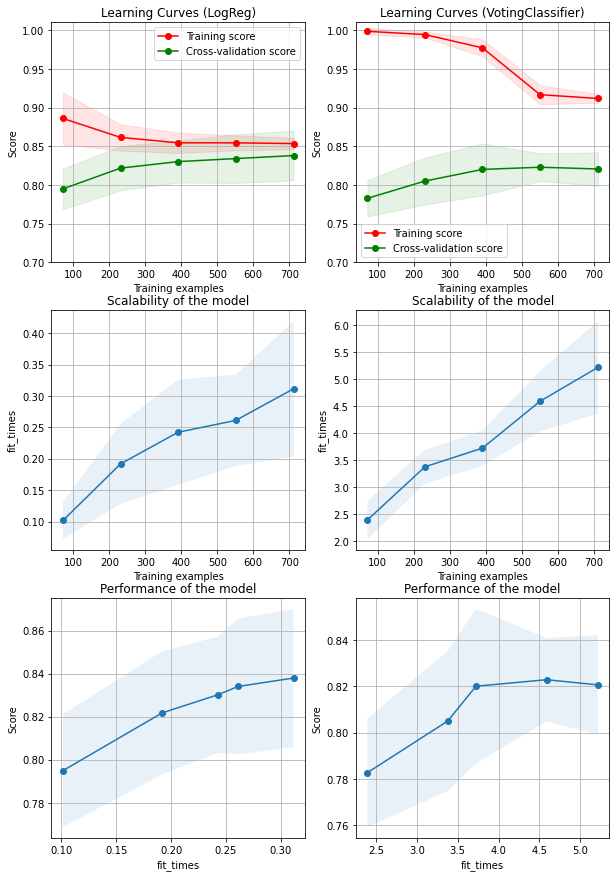

In [364]:
fig, axes = plt.subplots(3, 2, figsize=(10, 15))


title = "Learning Curves (LogReg)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

estimator = LogisticRegression(random_state=0)
plot_learning_curve(estimator, title, x_first, y, axes=axes[:, 0], ylim=(0.7, 1.01),
                    cv=cv, n_jobs=-1)

title = "Learning Curves (VotingClassifier)"
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = vt
plot_learning_curve(estimator, title, x_exp, y, axes=axes[:, 1], ylim=(0.7, 1.01),
                    cv=cv, n_jobs=-1)

plt.show()

VotingClassifier is overfitting way more than Log Reg

# Experiment 2

train_scores_mean:  0.8376404494382023 
test_scores_mean 0.7966480446927374


<module 'matplotlib.pyplot' from 'C:\\Users\\ticom\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

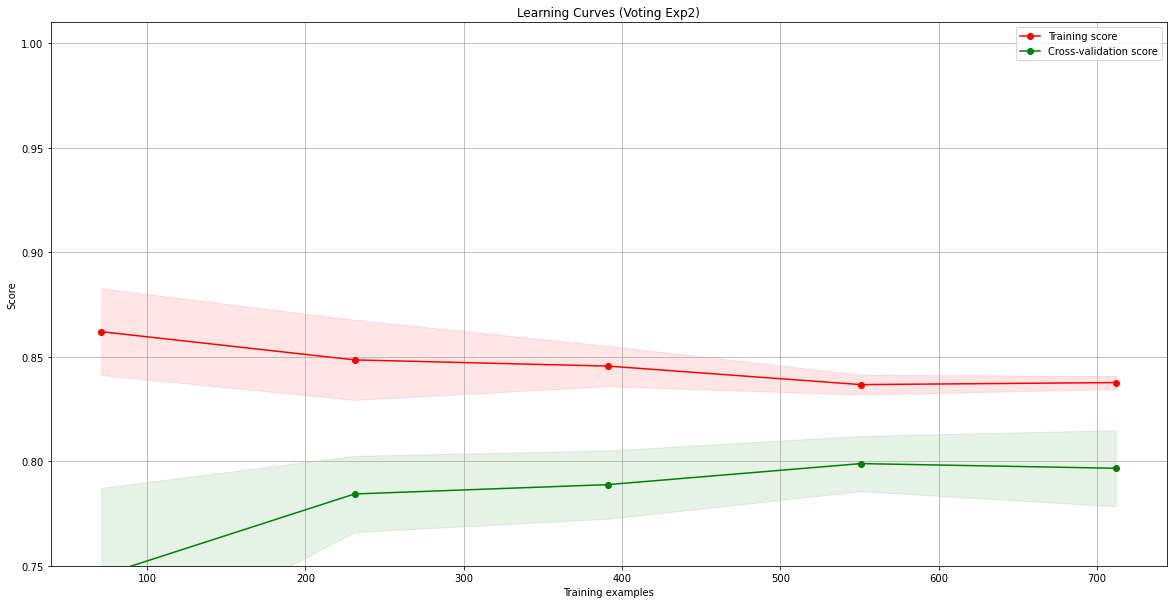

In [430]:
# pipeline for imputing missing values
impute_pipe = Pipeline([
   ('Fix dtypes',dtype_fix(Pclass_type='O',SibSpParch_type='O')),    # transforms Pclass, Parch and SibSp in 'object' and they get onehot encoded
   ('Cabin imputer',CategoricalImputer(variables=['Cabin'], fill_value='???')),
   ('Embarked imputer',CategoricalImputer(variables=['Embarked'], imputation_method='frequent')),
   ('Age by group', AgeGroupImputer(group=['Pclass','Sex'])),
   ('Numeric imputer', MeanMedianImputer(variables=['Fare'],imputation_method='median'))
                    ])

# pipeline for extracting features
ext_pp = make_pipeline(
    get_feat_name(family=True, title=True),
    Cabin_code(code=True,size=False)
                    )

# pipeline for categorical variables preprocessing 
#encode_var = ['Embarked','Name_title','Name_family','Cabin_code']
onehot_ct = make_column_transformer((OneHotSK(handle_unknown='ignore'),make_column_selector(dtype_include='object')))
cat_pp = Pipeline([
    ('Binary encode Sex',Mapper(features=['Sex'],map_dict = sex_map)),
    ('OneHot', onehot_ct )
            ])

# pipeline for numeric variables preprocessing 
num_pp = Pipeline([
    ('scaler',ColumnTransformer([('Numeric Vars',StandardScaler(),['Fare','Age','SibSp','Parch'])], remainder='passthrough'))
                ])

# Outlier haandling
out_hand = Winsorizer(variables=["Age","Fare"],capping_method='quantiles', fold=0.05)

seed=42
#### MODELS
clf1 = LogisticRegression(random_state=seed)
clf2 = RandomForestClassifier(random_state=seed)
clf3 = GradientBoostingClassifier(random_state=seed)
#clf4 = XGBClassifier(random_state=seed,eval_metric='error')
vt = VotingClassifier(voting='hard',estimators=[('lr', clf1), ('rf', clf2), ('gbc', clf3)])

# final pipeline
exp_pipe2 = Pipeline([
    ('Impute missing values',impute_pipe),
    ('Extract features',ext_pp), 
    ('RareLabels family', RareLabelEncoder(n_categories=10, variables=['Name_family'])),
#    ('RareLabels title', RareLabelEncoder(n_categories=15, variables=['Name_title'])),
    ('Drop bad features',DropFeatures(features_to_drop=['Name','Cabin','Ticket'])), # 'Ticket', 
    ('Outlier handling',out_hand),
    ('Categorical Preprocess', cat_pp),
#    ('Numeric Preprocess', num_pp),
#   ('Model', 
                      ])

# cross validation
#get_cross_score(exp_pipe2,cv=5)
#exp_pipe
x_exp2 = exp_pipe2.fit_transform(x)



title = "Learning Curves (Voting Exp2)"
estimator = LogisticRegression(random_state=0)
plot_learning_curve(estimator, title, x_exp2, y, ylim=(0.75, 1.01),
                    cv=cv, n_jobs=-1)

In [431]:
pipe1 = make_pipeline(exp_pipe2,LogisticRegression(random_state=0))
make_sub(pipe1,'sub15')

train_scores_mean:  0.9109550561797752 
test_scores_mean 0.805586592178771


<module 'matplotlib.pyplot' from 'C:\\Users\\ticom\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

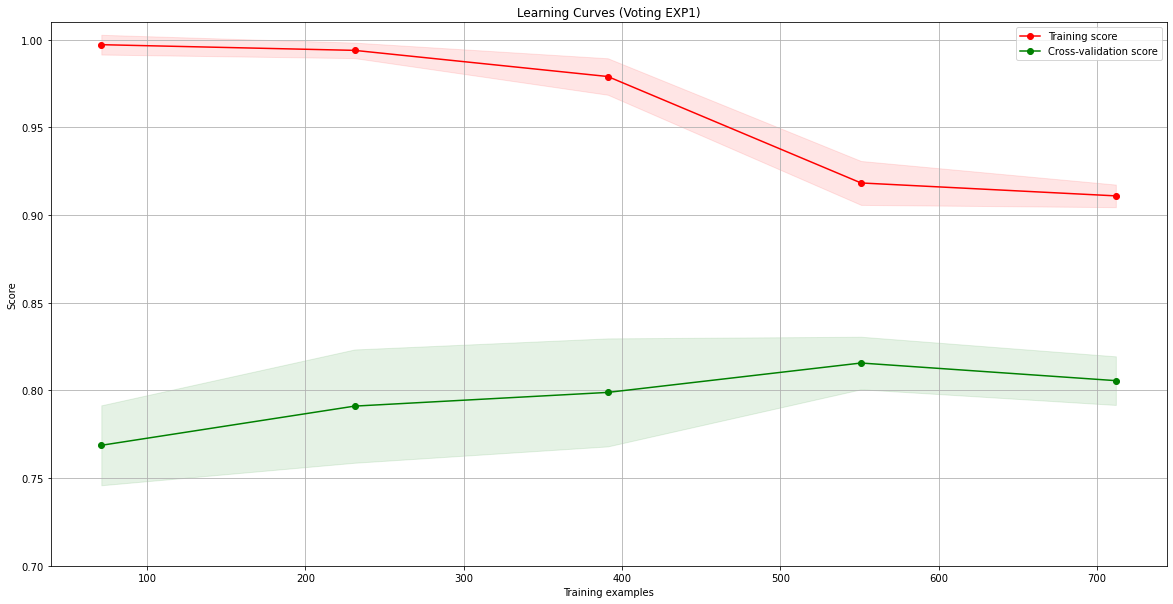

In [400]:
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

title = "Learning Curves (Voting EXP1)"
estimator = vt
plot_learning_curve(estimator, title, x_exp, y, ylim=(0.7, 1.01),
                    cv=cv, n_jobs=-1)

# 4. Models for Voting Classifier

In [259]:
pp_pipe = Pipeline([
    ('Impute missing values',impute_pipe),
    ('Extract features',ext_pp), 
    ('Drop bad features',DropFeatures(features_to_drop=['Name','Ticket', 'Cabin'])), 
    ('Categorical Preprocess', cat_pp),
#    ('Outlier handling',out_hand),
    ('Numeric Preprocess', num_pp)])
    
x_final = pp_pipe.fit_transform(x)

## 4.1 LightGBM

In [365]:
from lightgbm import LGBMClassifier

lgbm_pipe = Pipeline([
    ('Impute missing values',impute_pipe),
    ('Extract features',ext_pp), 
    ('Drop bad features',DropFeatures(features_to_drop=['Name','Ticket', 'Cabin'])), 
    ('Categorical Preprocess', cat_pp),
#    ('Outlier handling',out_hand),
    ('Numeric Preprocess', num_pp),
    ('RandomForest', LGBMClassifier(random_state=0))
                      ])

# cross validation
get_cross_score(lgbm_pipe,cv=5)

accuracy of 0.8218 and standard deviation of 0.02


In [273]:
lgbm_pipe.fit(x,y)
pred = lgbm_pipe.predict(df_pred)
data = {'PassengerId': df_pred.index,
             'Survived': pred}
sub1 = pd.DataFrame(data)
sub1.to_csv('Predições/Experiments_nb/sub9.csv',header=True, index=False)

[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=82
[LightGBM] [Warning] bagging_fraction is set=0.8158872171418485, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8158872171418485
[LightGBM] [Warning] lambda_l2 is set=0.0017022931496126555, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0017022931496126555
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


lgbm score = 0.74641. Super overfitted

# 4.2 GradientBoosting

In [221]:
gbc_pipe = Pipeline([
    ('Impute missing values',impute_pipe),
    ('Extract features',ext_pp), 
    ('Drop bad features',DropFeatures(features_to_drop=['Name','Ticket', 'Cabin'])), 
    ('Categorical Preprocess', cat_pp),
#    ('Outlier handling',out_hand),
    ('Numeric Preprocess', num_pp),
    ('RandomForest', GradientBoostingClassifier(random_state=0))
                      ])
# cross validation
get_cross_score(gbc_pipe,cv=5)

accuracy of 0.8443 and standard deviation of 0.0251


gcb score = 0.76315. Super overfitted

In [239]:
gbc_pipe.fit(x,y)
gcb_pred = gbc_pipe.predict(df_pred)
data_gcb = {'PassengerId': df_pred.index,
             'Survived': gcb_pred}
sub1 = pd.DataFrame(data_gcb)
sub1.to_csv('Predições/Experiments_nb/sub8.csv',header=True, index=False)

# 4.3 Voting Classsifier

In [244]:
lr = LogisticRegression(random_state=0)
rf = RandomForestClassifier(random_state=0)
lgbm = LGBMClassifier(random_state=0)
gbc = GradientBoostingClassifier(random_state=0)

voting_pipe = Pipeline([
    ('Impute missing values',impute_pipe),
    ('Extract features',ext_pp), 
    ('Drop bad features',DropFeatures(features_to_drop=['Name','Ticket', 'Cabin'])), 
    ('Categorical Preprocess', cat_pp),
#    ('Outlier handling',out_hand),
    ('Numeric Preprocess', num_pp),
    ('Voting Classifier', VotingClassifier(voting='hard',#weights= [1,1,1,1] ,
                                            estimators=[('LogReg', lr),
                                                        ('RandomForest', rf),
                                                        ('LightGBM', lgbm),
                                                        ('GradientBoosting', gbc)
                                                    ]))
    ])
     
# cross validation
get_cross_score(voting_pipe,cv=5)

accuracy of 0.8379 and standard deviation of 0.0183


In [245]:
voting_pipe.fit(x,y)
pred = voting_pipe.predict(df_pred)
data = {'PassengerId': df_pred.index,
             'Survived': pred}
pd.DataFrame(data).to_csv('Predições/Experiments_nb/sub10.csv',header=True, index=False)

kaggle score - voting = 0.78229

# 5. Error analysis

In [250]:
from sklearn.metrics import classification_report

voting_pipe.fit(x_train,y_train)
pred_val = voting_pipe.predict(x_test)

print(classification_report(y_test,pred_val))

              precision    recall  f1-score   support

           0       0.84      0.90      0.87       168
           1       0.82      0.71      0.76       100

    accuracy                           0.83       268
   macro avg       0.83      0.81      0.82       268
weighted avg       0.83      0.83      0.83       268



# 6. Hyper parameter tuning

In [267]:
from sklearn.metrics import accuracy_score
import optuna

# obejctive optimization function
def objective(trial, data=x, target=y):
  """ objetive function to be optmized by optuna """

  # split the data  
  train_x, valid_x, train_y, valid_y = train_test_split(data, target, test_size=0.3)
  # grid params
  lgbm_params ={
    'num_leaves': trial.suggest_int('num_leaves', 200, 1200),
    'max_depth': trial.suggest_int('max_depth', 7,12),
    'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 80,800),
    'learning_rate': trial.suggest_float('learning_rate', 0.01,0.2),
    'n_estimators' : trial.suggest_int('n_estimators',100, 900),
    'lambda_l2' : trial.suggest_float('lambda_l2', 1e-8, 0.01, log=True),
    'bagging_fraction': trial.suggest_float('bagging_fraction', 0.3,1),
    'bagging_freq': trial.suggest_int('bagging_freq', 1,5),
    'random_state': 0,
    'num_threads':-1}
  # the model
  lgbm_model = LGBMClassifier(verbose=0,**lgbm_params)
  # fit the data
  lgbm_model.fit(train_x, train_y)
  # predict
  pred = lgbm_model.predict(valid_x)
  # score
  score = accuracy_score(valid_y, pred)
  return score

In [263]:
# Create the study
study = optuna.create_study(direction="maximize")

[I 2021-10-02 06:48:23,451] A new study created in memory with name: no-name-88811abc-4f0a-4a3e-a169-cd03a17d6046


In [269]:
# Start the study
study.optimize(lambda trial: objective(trial,
                                       data=x_final,
                                       target=y),
               n_trials=50)

[LightGBM] [Warning] min_data_in_leaf is set=158, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=158
[LightGBM] [Warning] bagging_fraction is set=0.5874515670298752, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5874515670298752
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=0.007030441159188856, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.007030441159188856
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=158, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=158
[LightGBM] [Warning] bagging_fraction is set=0.5874515670298752, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5874515670298752
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2021-10-02 06:52:09,174] Trial 68 finished with value: 0.7985074626865671 and parameters: {'num_leaves': 477, 'max_depth': 12, 'min_data_in_leaf': 158, 'learning_rate': 0.08517054744423182, 'n_estimators': 497, 'lambda_l2': 0.007030441159188856, 'bagging_fraction': 0.5874515670298752, 'bagging_freq': 5}. Best is trial 22 with value: 0.8544776119402985.


[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] bagging_fraction is set=0.44057050630588485, subsample=1.0 will be ignored. Current value: bagging_fraction=0.44057050630588485
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=0.0022892543383015856, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0022892543383015856
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] bagging_fraction is set=0.44057050630588485, subsample=1.0 will be ignored. Current value: bagging_fraction=0.44057050630588485
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGB

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2021-10-02 06:52:14,094] Trial 69 finished with value: 0.7947761194029851 and parameters: {'num_leaves': 644, 'max_depth': 9, 'min_data_in_leaf': 81, 'learning_rate': 0.07472956852151555, 'n_estimators': 400, 'lambda_l2': 0.0022892543383015856, 'bagging_fraction': 0.44057050630588485, 'bagging_freq': 4}. Best is trial 22 with value: 0.8544776119402985.


[LightGBM] [Warning] min_data_in_leaf is set=182, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=182
[LightGBM] [Warning] bagging_fraction is set=0.6645005987998421, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6645005987998421
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=0.00040882027403356044, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00040882027403356044
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=182, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=182
[LightGBM] [Warning] bagging_fraction is set=0.6645005987998421, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6645005987998421
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[Light

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2021-10-02 06:52:17,152] Trial 70 finished with value: 0.8507462686567164 and parameters: {'num_leaves': 609, 'max_depth': 8, 'min_data_in_leaf': 182, 'learning_rate': 0.06613139674001994, 'n_estimators': 215, 'lambda_l2': 0.00040882027403356044, 'bagging_fraction': 0.6645005987998421, 'bagging_freq': 5}. Best is trial 22 with value: 0.8544776119402985.


[LightGBM] [Warning] min_data_in_leaf is set=283, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=283
[LightGBM] [Warning] bagging_fraction is set=0.664087221238269, subsample=1.0 will be ignored. Current value: bagging_fraction=0.664087221238269
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=0.0003712444308035723, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0003712444308035723
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=283, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=283
[LightGBM] [Warning] bagging_fraction is set=0.664087221238269, subsample=1.0 will be ignored. Current value: bagging_fraction=0.664087221238269
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

[I 2021-10-02 06:52:18,307] Trial 71 finished with value: 0.6268656716417911 and parameters: {'num_leaves': 568, 'max_depth': 12, 'min_data_in_leaf': 283, 'learning_rate': 0.08288173134720742, 'n_estimators': 107, 'lambda_l2': 0.0003712444308035723, 'bagging_fraction': 0.664087221238269, 'bagging_freq': 5}. Best is trial 22 with value: 0.8544776119402985.


[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] min_data_in_leaf is set=122, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=122
[LightGBM] [Warning] bagging_fraction is set=0.6819942630497873, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6819942630497873
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: nu

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2021-10-02 06:52:23,531] Trial 72 finished with value: 0.7873134328358209 and parameters: {'num_leaves': 620, 'max_depth': 8, 'min_data_in_leaf': 122, 'learning_rate': 0.06542343705746663, 'n_estimators': 226, 'lambda_l2': 0.0038512167813147527, 'bagging_fraction': 0.6819942630497873, 'bagging_freq': 5}. Best is trial 22 with value: 0.8544776119402985.


[LightGBM] [Warning] min_data_in_leaf is set=137, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=137
[LightGBM] [Warning] bagging_fraction is set=0.5327485294800013, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5327485294800013
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=0.0008756447899896448, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0008756447899896448
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=137, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=137
[LightGBM] [Warning] bagging_fraction is set=0.5327485294800013, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5327485294800013
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGB

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2021-10-02 06:52:25,282] Trial 73 finished with value: 0.8246268656716418 and parameters: {'num_leaves': 508, 'max_depth': 7, 'min_data_in_leaf': 137, 'learning_rate': 0.055977415536206235, 'n_estimators': 165, 'lambda_l2': 0.0008756447899896448, 'bagging_fraction': 0.5327485294800013, 'bagging_freq': 5}. Best is trial 22 with value: 0.8544776119402985.


[LightGBM] [Warning] min_data_in_leaf is set=175, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=175
[LightGBM] [Warning] bagging_fraction is set=0.6053937715548701, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6053937715548701
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=0.0022502954385598003, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0022502954385598003
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=175, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=175
[LightGBM] [Warning] bagging_fraction is set=0.6053937715548701, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6053937715548701
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGB

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2021-10-02 06:52:27,235] Trial 74 finished with value: 0.7798507462686567 and parameters: {'num_leaves': 407, 'max_depth': 9, 'min_data_in_leaf': 175, 'learning_rate': 0.09881532466425254, 'n_estimators': 442, 'lambda_l2': 0.0022502954385598003, 'bagging_fraction': 0.6053937715548701, 'bagging_freq': 5}. Best is trial 22 with value: 0.8544776119402985.


[LightGBM] [Warning] min_data_in_leaf is set=769, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=769
[LightGBM] [Warning] bagging_fraction is set=0.6403836955243096, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6403836955243096
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=0.0010773593922674069, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0010773593922674069
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] There are no meaningful features, as all feature values are constant.
[LightGBM] [Warning] min_data_in_leaf is set=769, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=769
[LightGBM] [Warning] bagging_fraction is set=0.6403836955243096, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6403836955243096
[LightGBM] [Warnin

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

[I 2021-10-02 06:52:28,059] Trial 75 finished with value: 0.6305970149253731 and parameters: {'num_leaves': 669, 'max_depth': 8, 'min_data_in_leaf': 769, 'learning_rate': 0.06720293896737466, 'n_estimators': 202, 'lambda_l2': 0.0010773593922674069, 'bagging_fraction': 0.6403836955243096, 'bagging_freq': 5}. Best is trial 22 with value: 0.8544776119402985.


[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2021-10-02 06:52:29,038] Trial 76 finished with value: 0.7761194029850746 and parameters: {'num_leaves': 452, 'max_depth': 12, 'min_data_in_leaf': 108, 'learning_rate': 0.17056243520291878, 'n_estimators': 151, 'lambda_l2': 0.0064714787968223105, 'bagging_fraction': 0.5798307907731157, 'bagging_freq': 5}. Best is trial 22 with value: 0.8544776119402985.


[LightGBM] [Warning] min_data_in_leaf is set=498, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=498
[LightGBM] [Warning] bagging_fraction is set=0.6294869671744289, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6294869671744289
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=0.009968657437409911, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.009968657437409911
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] There are no meaningful features, as all feature values are constant.
[LightGBM] [Warning] min_data_in_leaf is set=498, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=498
[LightGBM] [Warning] bagging_fraction is set=0.6294869671744289, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6294869671744289
[LightGBM] [Warning]

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

[I 2021-10-02 06:52:30,792] Trial 77 finished with value: 0.6119402985074627 and parameters: {'num_leaves': 325, 'max_depth': 10, 'min_data_in_leaf': 498, 'learning_rate': 0.07780886195033476, 'n_estimators': 469, 'lambda_l2': 0.009968657437409911, 'bagging_fraction': 0.6294869671744289, 'bagging_freq': 5}. Best is trial 22 with value: 0.8544776119402985.



[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2021-10-02 06:52:33,271] Trial 78 finished with value: 0.8544776119402985 and parameters: {'num_leaves': 616, 'max_depth': 12, 'min_data_in_leaf': 151, 'learning_rate': 0.13839379374227892, 'n_estimators': 330, 'lambda_l2': 0.0033609051699241862, 'bagging_fraction': 0.8209670074318574, 'bagging_freq': 5}. Best is trial 22 with value: 0.8544776119402985.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2021-10-02 06:52:34,548] Trial 79 finished with value: 0.8208955223880597 and parameters: {'num_leaves': 615, 'max_depth': 12, 'min_data_in_leaf': 154, 'learning_rate': 0.1267898746336324, 'n_estimators': 285, 'lambda_l2': 0.0034685550566176636, 'bagging_fraction': 0.8232054361213369, 'bagging_freq': 5}. Best is trial 22 with value: 0.8544776119402985.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2021-10-02 06:52:35,994] Trial 80 finished with value: 0.7947761194029851 and parameters: {'num_leaves': 552, 'max_depth': 7, 'min_data_in_leaf': 204, 'learning_rate': 0.13678285145417637, 'n_estimators': 327, 'lambda_l2': 8.32866379259372e-07, 'bagging_fraction': 0.7892148032171016, 'bagging_freq': 4}. Best is trial 22 with value: 0.8544776119402985.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_data_in_leaf is set=185, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=185
[LightGBM] [Warning] bagging_fraction is set=0.8571869013720297, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8571869013720297
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=0.004132765110549353, reg_lambda=0.0 will be ignored. Current val

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2021-10-02 06:52:37,593] Trial 81 finished with value: 0.8022388059701493 and parameters: {'num_leaves': 599, 'max_depth': 12, 'min_data_in_leaf': 185, 'learning_rate': 0.1207879051756032, 'n_estimators': 234, 'lambda_l2': 0.004132765110549353, 'bagging_fraction': 0.8571869013720297, 'bagging_freq': 5}. Best is trial 22 with value: 0.8544776119402985.


[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] bagging_fraction is set=0.8175495808340844, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8175495808340844
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=0.0024132320584811873, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0024132320584811873
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] bagging_fraction is set=0.8175495808340844, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8175495808340844
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2021-10-02 06:52:39,660] Trial 82 finished with value: 0.8470149253731343 and parameters: {'num_leaves': 523, 'max_depth': 12, 'min_data_in_leaf': 93, 'learning_rate': 0.04965936194345538, 'n_estimators': 348, 'lambda_l2': 0.0024132320584811873, 'bagging_fraction': 0.8175495808340844, 'bagging_freq': 5}. Best is trial 22 with value: 0.8544776119402985.


[LightGBM] [Warning] min_data_in_leaf is set=135, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=135
[LightGBM] [Warning] bagging_fraction is set=0.3226271809494877, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3226271809494877
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=0.00245165397022879, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00245165397022879
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=135, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=135
[LightGBM] [Warning] bagging_fraction is set=0.3226271809494877, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3226271809494877
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

[I 2021-10-02 06:52:41,763] Trial 83 finished with value: 0.6007462686567164 and parameters: {'num_leaves': 504, 'max_depth': 12, 'min_data_in_leaf': 135, 'learning_rate': 0.03669031210439698, 'n_estimators': 358, 'lambda_l2': 0.00245165397022879, 'bagging_fraction': 0.3226271809494877, 'bagging_freq': 5}. Best is trial 22 with value: 0.8544776119402985.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] bagging_fraction is set=0.9531223811856413, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9531223811856413
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=0.0048358767043301795, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0048358767043301795
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] bagging_fraction is set=0.9531223811856413, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9531223811856413
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2021-10-02 06:52:43,078] Trial 84 finished with value: 0.8059701492537313 and parameters: {'num_leaves': 475, 'max_depth': 12, 'min_data_in_leaf': 95, 'learning_rate': 0.049533594563320196, 'n_estimators': 289, 'lambda_l2': 0.0048358767043301795, 'bagging_fraction': 0.9531223811856413, 'bagging_freq': 5}. Best is trial 22 with value: 0.8544776119402985.


[LightGBM] [Warning] min_data_in_leaf is set=125, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=125
[LightGBM] [Warning] bagging_fraction is set=0.9070288473432865, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9070288473432865
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=0.0014793542867380968, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0014793542867380968
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=125, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=125
[LightGBM] [Warning] bagging_fraction is set=0.9070288473432865, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9070288473432865
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGB

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2021-10-02 06:52:44,308] Trial 85 finished with value: 0.8097014925373134 and parameters: {'num_leaves': 590, 'max_depth': 12, 'min_data_in_leaf': 125, 'learning_rate': 0.1571896112584632, 'n_estimators': 250, 'lambda_l2': 0.0014793542867380968, 'bagging_fraction': 0.9070288473432865, 'bagging_freq': 5}. Best is trial 22 with value: 0.8544776119402985.


[LightGBM] [Warning] min_data_in_leaf is set=237, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=237
[LightGBM] [Warning] bagging_fraction is set=0.8774527433830955, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8774527433830955
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=0.0006500480598485515, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006500480598485515
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=237, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=237
[LightGBM] [Warning] bagging_fraction is set=0.8774527433830955, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8774527433830955
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGB

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2021-10-02 06:52:45,500] Trial 86 finished with value: 0.7873134328358209 and parameters: {'num_leaves': 660, 'max_depth': 12, 'min_data_in_leaf': 237, 'learning_rate': 0.1434549954822229, 'n_estimators': 310, 'lambda_l2': 0.0006500480598485515, 'bagging_fraction': 0.8774527433830955, 'bagging_freq': 5}. Best is trial 22 with value: 0.8544776119402985.


[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] bagging_fraction is set=0.7522808158128701, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7522808158128701
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=0.001771283346201706, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001771283346201706
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] bagging_fraction is set=0.7522808158128701, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7522808158128701
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Wa

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2021-10-02 06:52:47,054] Trial 87 finished with value: 0.8134328358208955 and parameters: {'num_leaves': 805, 'max_depth': 11, 'min_data_in_leaf': 91, 'learning_rate': 0.05859953100925959, 'n_estimators': 413, 'lambda_l2': 0.001771283346201706, 'bagging_fraction': 0.7522808158128701, 'bagging_freq': 4}. Best is trial 22 with value: 0.8544776119402985.


[LightGBM] [Warning] min_data_in_leaf is set=159, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=159
[LightGBM] [Warning] bagging_fraction is set=0.8079628917575007, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8079628917575007
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=0.00048489937574707544, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00048489937574707544
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=159, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=159
[LightGBM] [Warning] bagging_fraction is set=0.8079628917575007, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8079628917575007
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[Light

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2021-10-02 06:52:48,335] Trial 88 finished with value: 0.8283582089552238 and parameters: {'num_leaves': 526, 'max_depth': 12, 'min_data_in_leaf': 159, 'learning_rate': 0.07094510623746876, 'n_estimators': 383, 'lambda_l2': 0.00048489937574707544, 'bagging_fraction': 0.8079628917575007, 'bagging_freq': 5}. Best is trial 22 with value: 0.8544776119402985.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2021-10-02 06:52:49,903] Trial 89 finished with value: 0.8208955223880597 and parameters: {'num_leaves': 236, 'max_depth': 11, 'min_data_in_leaf': 82, 'learning_rate': 0.04975200698312496, 'n_estimators': 342, 'lambda_l2': 0.0009233828994121684, 'bagging_fraction': 0.8527077636101085, 'bagging_freq': 4}. Best is trial 22 with value: 0.8544776119402985.


[LightGBM] [Warning] min_data_in_leaf is set=133, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=133
[LightGBM] [Warning] bagging_fraction is set=0.7855604199170662, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7855604199170662
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=0.007250105918065757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.007250105918065757
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=133, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=133
[LightGBM] [Warning] bagging_fraction is set=0.7855604199170662, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7855604199170662
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2021-10-02 06:52:50,889] Trial 90 finished with value: 0.8283582089552238 and parameters: {'num_leaves': 563, 'max_depth': 9, 'min_data_in_leaf': 133, 'learning_rate': 0.1512795297712747, 'n_estimators': 201, 'lambda_l2': 0.007250105918065757, 'bagging_fraction': 0.7855604199170662, 'bagging_freq': 5}. Best is trial 22 with value: 0.8544776119402985.


[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] bagging_fraction is set=0.6965776226528604, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6965776226528604
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=2.0092506106389695e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0092506106389695e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] bagging_fraction is set=0.6965776226528604, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6965776226528604
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2021-10-02 06:52:52,573] Trial 91 finished with value: 0.835820895522388 and parameters: {'num_leaves': 681, 'max_depth': 10, 'min_data_in_leaf': 80, 'learning_rate': 0.10873007910773695, 'n_estimators': 362, 'lambda_l2': 2.0092506106389695e-07, 'bagging_fraction': 0.6965776226528604, 'bagging_freq': 5}. Best is trial 22 with value: 0.8544776119402985.


[LightGBM] [Warning] min_data_in_leaf is set=119, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=119
[LightGBM] [Warning] bagging_fraction is set=0.827200547080996, subsample=1.0 will be ignored. Current value: bagging_fraction=0.827200547080996
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=0.001605902679150599, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001605902679150599
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=119, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=119
[LightGBM] [Warning] bagging_fraction is set=0.827200547080996, subsample=1.0 will be ignored. Current value: bagging_fraction=0.827200547080996
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Wa

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2021-10-02 06:52:55,114] Trial 92 finished with value: 0.8059701492537313 and parameters: {'num_leaves': 1127, 'max_depth': 12, 'min_data_in_leaf': 119, 'learning_rate': 0.06157786332351213, 'n_estimators': 516, 'lambda_l2': 0.001605902679150599, 'bagging_fraction': 0.827200547080996, 'bagging_freq': 5}. Best is trial 22 with value: 0.8544776119402985.


[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] bagging_fraction is set=0.6622282561053562, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6622282561053562
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=0.0026864329566217747, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0026864329566217747
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] bagging_fraction is set=0.6622282561053562, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6622282561053562
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGB

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2021-10-02 06:52:56,478] Trial 93 finished with value: 0.8022388059701493 and parameters: {'num_leaves': 495, 'max_depth': 12, 'min_data_in_leaf': 110, 'learning_rate': 0.029972346560151436, 'n_estimators': 419, 'lambda_l2': 0.0026864329566217747, 'bagging_fraction': 0.6622282561053562, 'bagging_freq': 5}. Best is trial 22 with value: 0.8544776119402985.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2021-10-02 06:52:58,337] Trial 94 finished with value: 0.8022388059701493 and parameters: {'num_leaves': 445, 'max_depth': 12, 'min_data_in_leaf': 95, 'learning_rate': 0.13136645353575618, 'n_estimators': 457, 'lambda_l2': 0.003609399161190999, 'bagging_fraction': 0.7319599045073456, 'bagging_freq': 5}. Best is trial 22 with value: 0.8544776119402985.


[LightGBM] [Warning] min_data_in_leaf is set=170, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=170
[LightGBM] [Warning] bagging_fraction is set=0.5461349228740086, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5461349228740086
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=0.005341136738296243, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005341136738296243
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=170, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=170
[LightGBM] [Warning] bagging_fraction is set=0.5461349228740086, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5461349228740086
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

[I 2021-10-02 06:53:00,087] Trial 95 finished with value: 0.8059701492537313 and parameters: {'num_leaves': 524, 'max_depth': 12, 'min_data_in_leaf': 170, 'learning_rate': 0.19264544802281375, 'n_estimators': 490, 'lambda_l2': 0.005341136738296243, 'bagging_fraction': 0.5461349228740086, 'bagging_freq': 5}. Best is trial 22 with value: 0.8544776119402985.


[LightGBM] [Warning] min_data_in_leaf is set=145, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=145
[LightGBM] [Warning] bagging_fraction is set=0.8673383738182042, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8673383738182042
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=0.001388120205956973, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001388120205956973
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=145, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=145
[LightGBM] [Warning] bagging_fraction is set=0.8673383738182042, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8673383738182042
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2021-10-02 06:53:01,524] Trial 96 finished with value: 0.7910447761194029 and parameters: {'num_leaves': 598, 'max_depth': 11, 'min_data_in_leaf': 145, 'learning_rate': 0.16556428725336286, 'n_estimators': 396, 'lambda_l2': 0.001388120205956973, 'bagging_fraction': 0.8673383738182042, 'bagging_freq': 5}. Best is trial 22 with value: 0.8544776119402985.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current valu

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2021-10-02 06:53:02,930] Trial 97 finished with value: 0.7649253731343284 and parameters: {'num_leaves': 937, 'max_depth': 12, 'min_data_in_leaf': 97, 'learning_rate': 0.08212601619893337, 'n_estimators': 306, 'lambda_l2': 0.00025951059541996443, 'bagging_fraction': 0.5996217276187241, 'bagging_freq': 5}. Best is trial 22 with value: 0.8544776119402985.


[LightGBM] [Warning] min_data_in_leaf is set=122, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=122
[LightGBM] [Warning] bagging_fraction is set=0.8347221850728206, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8347221850728206
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=0.0020170386004910745, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0020170386004910745
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=122, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=122
[LightGBM] [Warning] bagging_fraction is set=0.8347221850728206, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8347221850728206
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGB

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2021-10-02 06:53:04,305] Trial 98 finished with value: 0.8097014925373134 and parameters: {'num_leaves': 555, 'max_depth': 12, 'min_data_in_leaf': 122, 'learning_rate': 0.13692288516983186, 'n_estimators': 337, 'lambda_l2': 0.0020170386004910745, 'bagging_fraction': 0.8347221850728206, 'bagging_freq': 5}. Best is trial 22 with value: 0.8544776119402985.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

[I 2021-10-02 06:53:05,452] Trial 99 finished with value: 0.6156716417910447 and parameters: {'num_leaves': 744, 'max_depth': 8, 'min_data_in_leaf': 620, 'learning_rate': 0.09021786568128096, 'n_estimators': 428, 'lambda_l2': 0.0007964315608990926, 'bagging_fraction': 0.7418086462346454, 'bagging_freq': 5}. Best is trial 22 with value: 0.8544776119402985.


[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2021-10-02 06:53:06,578] Trial 100 finished with value: 0.832089552238806 and parameters: {'num_leaves': 422, 'max_depth': 11, 'min_data_in_leaf': 151, 'learning_rate': 0.15381283003132493, 'n_estimators': 279, 'lambda_l2': 1.4223125286168784e-08, 'bagging_fraction': 0.8169283505765904, 'bagging_freq': 4}. Best is trial 22 with value: 0.8544776119402985.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2021-10-02 06:53:08,407] Trial 101 finished with value: 0.7947761194029851 and parameters: {'num_leaves': 395, 'max_depth': 12, 'min_data_in_leaf': 113, 'learning_rate': 0.17419029293464433, 'n_estimators': 380, 'lambda_l2': 0.003018809055526792, 'bagging_fraction': 0.9285067529660909, 'bagging_freq': 2}. Best is trial 22 with value: 0.8544776119402985.


[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] bagging_fraction is set=0.8904366824740643, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8904366824740643
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=0.0012379900240640494, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0012379900240640494
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] bagging_fraction is set=0.8904366824740643, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8904366824740643
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2021-10-02 06:53:09,903] Trial 102 finished with value: 0.832089552238806 and parameters: {'num_leaves': 641, 'max_depth': 12, 'min_data_in_leaf': 96, 'learning_rate': 0.0700739583707816, 'n_estimators': 355, 'lambda_l2': 0.0012379900240640494, 'bagging_fraction': 0.8904366824740643, 'bagging_freq': 5}. Best is trial 22 with value: 0.8544776119402985.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_data_in_leaf is set=132, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=132
[LightGBM] [Warning] bagging_fraction is set=0.6292828777349935, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6292828777349935
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=0.00749804153928034, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00749804153928034
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=132, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=132
[LightGBM] [Warning] bagging_fraction is set=0.6292828777349935, subsample=1.0 will be ignored. Current value:

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2021-10-02 06:53:11,149] Trial 103 finished with value: 0.7910447761194029 and parameters: {'num_leaves': 491, 'max_depth': 12, 'min_data_in_leaf': 132, 'learning_rate': 0.1479468066933313, 'n_estimators': 445, 'lambda_l2': 0.00749804153928034, 'bagging_fraction': 0.6292828777349935, 'bagging_freq': 5}. Best is trial 22 with value: 0.8544776119402985.


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_fraction is set=0.7705416632448265, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7705416632448265
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=0.001976581068911999, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001976581068911999
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_fraction is set=0.7705416632448265, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7705416632448265
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2021-10-02 06:53:12,483] Trial 104 finished with value: 0.8059701492537313 and parameters: {'num_leaves': 856, 'max_depth': 12, 'min_data_in_leaf': 100, 'learning_rate': 0.1617073460057675, 'n_estimators': 406, 'lambda_l2': 0.001976581068911999, 'bagging_fraction': 0.7705416632448265, 'bagging_freq': 5}. Best is trial 22 with value: 0.8544776119402985.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2021-10-02 06:53:14,393] Trial 105 finished with value: 0.746268656716418 and parameters: {'num_leaves': 578, 'max_depth': 12, 'min_data_in_leaf': 170, 'learning_rate': 0.04146366484675956, 'n_estimators': 463, 'lambda_l2': 0.004735136243554164, 'bagging_fraction': 0.5715915527618203, 'bagging_freq': 5}. Best is trial 22 with value: 0.8544776119402985.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2021-10-02 06:53:16,390] Trial 106 finished with value: 0.8208955223880597 and parameters: {'num_leaves': 523, 'max_depth': 12, 'min_data_in_leaf': 116, 'learning_rate': 0.1439133810977289, 'n_estimators': 540, 'lambda_l2': 0.00044324514893139975, 'bagging_fraction': 0.7951725880831566, 'bagging_freq': 5}. Best is trial 22 with value: 0.8544776119402985.


[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] bagging_fraction is set=0.6959057490205903, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6959057490205903
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=0.002654035234345871, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002654035234345871
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] bagging_fraction is set=0.6959057490205903, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6959057490205903
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Wa

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2021-10-02 06:53:18,195] Trial 107 finished with value: 0.8246268656716418 and parameters: {'num_leaves': 700, 'max_depth': 12, 'min_data_in_leaf': 80, 'learning_rate': 0.13800309697632338, 'n_estimators': 476, 'lambda_l2': 0.002654035234345871, 'bagging_fraction': 0.6959057490205903, 'bagging_freq': 5}. Best is trial 22 with value: 0.8544776119402985.


[LightGBM] [Warning] min_data_in_leaf is set=144, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=144
[LightGBM] [Warning] bagging_fraction is set=0.6752411922492129, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6752411922492129
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=0.0010314410972562232, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0010314410972562232
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=144, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=144
[LightGBM] [Warning] bagging_fraction is set=0.6752411922492129, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6752411922492129
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGB

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2021-10-02 06:53:19,040] Trial 108 finished with value: 0.8022388059701493 and parameters: {'num_leaves': 201, 'max_depth': 12, 'min_data_in_leaf': 144, 'learning_rate': 0.07512055477237337, 'n_estimators': 247, 'lambda_l2': 0.0010314410972562232, 'bagging_fraction': 0.6752411922492129, 'bagging_freq': 5}. Best is trial 22 with value: 0.8544776119402985.


[LightGBM] [Warning] min_data_in_leaf is set=396, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=396
[LightGBM] [Warning] bagging_fraction is set=0.48100078760548604, subsample=1.0 will be ignored. Current value: bagging_fraction=0.48100078760548604
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=1.6604993727126565e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6604993727126565e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] There are no meaningful features, as all feature values are constant.
[LightGBM] [Warning] min_data_in_leaf is set=396, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=396
[LightGBM] [Warning] bagging_fraction is set=0.48100078760548604, subsample=1.0 will be ignored. Current value: bagging_fraction=0.48100078760548604
[LightGBM] [

[I 2021-10-02 06:53:19,545] Trial 109 finished with value: 0.6007462686567164 and parameters: {'num_leaves': 1167, 'max_depth': 12, 'min_data_in_leaf': 396, 'learning_rate': 0.17652803964804437, 'n_estimators': 134, 'lambda_l2': 1.6604993727126565e-05, 'bagging_fraction': 0.48100078760548604, 'bagging_freq': 5}. Best is trial 22 with value: 0.8544776119402985.


[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[I 2021-10-02 06:53:21,410] Trial 110 finished with value: 0.6455223880597015 and parameters: {'num_leaves': 618, 'max_depth': 12, 'min_data_in_leaf': 202, 'learning_rate': 0.13037924215615235, 'n_estimators': 516, 'lambda_l2': 0.0006289416434797833, 'bagging_fraction': 0.6458792097728615, 'bagging_freq': 5}. Best is trial 22 with value: 0.8544776119402985.


[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2021-10-02 06:53:22,469] Trial 111 finished with value: 0.7761194029850746 and parameters: {'num_leaves': 467, 'max_depth': 10, 'min_data_in_leaf': 183, 'learning_rate': 0.09513389312645945, 'n_estimators': 322, 'lambda_l2': 0.003684744179137336, 'bagging_fraction': 0.7165128585088225, 'bagging_freq': 5}. Best is trial 22 with value: 0.8544776119402985.


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_fraction is set=0.7543236407470496, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7543236407470496
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=0.0007344979428091495, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0007344979428091495
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_fraction is set=0.7543236407470496, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7543236407470496
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGB

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2021-10-02 06:53:23,835] Trial 112 finished with value: 0.832089552238806 and parameters: {'num_leaves': 547, 'max_depth': 12, 'min_data_in_leaf': 100, 'learning_rate': 0.1866567369598871, 'n_estimators': 370, 'lambda_l2': 0.0007344979428091495, 'bagging_fraction': 0.7543236407470496, 'bagging_freq': 5}. Best is trial 22 with value: 0.8544776119402985.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2021-10-02 06:53:25,970] Trial 113 finished with value: 0.8507462686567164 and parameters: {'num_leaves': 1033, 'max_depth': 12, 'min_data_in_leaf': 128, 'learning_rate': 0.19949890760017291, 'n_estimators': 434, 'lambda_l2': 0.0013759105961214024, 'bagging_fraction': 0.8050133223638054, 'bagging_freq': 5}. Best is trial 22 with value: 0.8544776119402985.


[LightGBM] [Warning] min_data_in_leaf is set=127, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=127
[LightGBM] [Warning] bagging_fraction is set=0.8094986463815563, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8094986463815563
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=0.0016081414905213841, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0016081414905213841
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=127, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=127
[LightGBM] [Warning] bagging_fraction is set=0.8094986463815563, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8094986463815563
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGB

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-10-02 06:53:27,948] Trial 114 finished with value: 0.8246268656716418 and parameters: {'num_leaves': 1086, 'max_depth': 12, 'min_data_in_leaf': 127, 'learning_rate': 0.18215401608037776, 'n_estimators': 584, 'lambda_l2': 0.0016081414905213841, 'bagging_fraction': 0.8094986463815563, 'bagging_freq': 5}. Best is trial 22 with value: 0.8544776119402985.


[LightGBM] [Warning] min_data_in_leaf is set=114, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=114
[LightGBM] [Warning] bagging_fraction is set=0.8437215320165596, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8437215320165596
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=0.008054074842517479, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.008054074842517479
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=114, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=114
[LightGBM] [Warning] bagging_fraction is set=0.8437215320165596, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8437215320165596
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2021-10-02 06:53:29,627] Trial 115 finished with value: 0.8171641791044776 and parameters: {'num_leaves': 989, 'max_depth': 12, 'min_data_in_leaf': 114, 'learning_rate': 0.010322792161719843, 'n_estimators': 440, 'lambda_l2': 0.008054074842517479, 'bagging_fraction': 0.8437215320165596, 'bagging_freq': 5}. Best is trial 22 with value: 0.8544776119402985.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_data_in_leaf is set=153, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=153
[LightGBM] [Warning] bagging_fraction is set=0.8295149423532182, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8295149423532182
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=0.005392677255976772, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005392677255976772
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=153, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=153
[LightGBM] [Warning] bagging_frac

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2021-10-02 06:53:31,002] Trial 116 finished with value: 0.835820895522388 and parameters: {'num_leaves': 1031, 'max_depth': 12, 'min_data_in_leaf': 153, 'learning_rate': 0.19404923313819436, 'n_estimators': 391, 'lambda_l2': 0.005392677255976772, 'bagging_fraction': 0.8295149423532182, 'bagging_freq': 5}. Best is trial 22 with value: 0.8544776119402985.


[LightGBM] [Warning] min_data_in_leaf is set=135, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=135
[LightGBM] [Warning] bagging_fraction is set=0.7751907633292662, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7751907633292662
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=0.0020731689750989723, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0020731689750989723
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=135, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=135
[LightGBM] [Warning] bagging_fraction is set=0.7751907633292662, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7751907633292662
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGB

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2021-10-02 06:53:33,433] Trial 117 finished with value: 0.7910447761194029 and parameters: {'num_leaves': 1040, 'max_depth': 12, 'min_data_in_leaf': 135, 'learning_rate': 0.16859968689650534, 'n_estimators': 455, 'lambda_l2': 0.0020731689750989723, 'bagging_fraction': 0.7751907633292662, 'bagging_freq': 5}. Best is trial 22 with value: 0.8544776119402985.


In [270]:
print("Number of finished trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    '{}': {},".format(key, value))

lgbm_bestparams = trial.params

Number of finished trials: 118
Best trial:
  Value: 0.8544776119402985
  Params: 
    'num_leaves': 528,
    'max_depth': 12,
    'min_data_in_leaf': 82,
    'learning_rate': 0.14736436172236436,
    'n_estimators': 335,
    'lambda_l2': 0.0017022931496126555,
    'bagging_fraction': 0.8158872171418485,
    'bagging_freq': 5,


In [ ]:
Best trial:
  Value: 0.8544776119402985
  Params: 
    'num_leaves': 528,
    'max_depth': 12,
    'min_data_in_leaf': 82,
    'learning_rate': 0.14736436172236436,
    'n_estimators': 335,
    'lambda_l2': 0.0017022931496126555,
    'bagging_fraction': 0.8158872171418485,
    'bagging_freq': 5,

In [ ]:
lgbm_pipe.fit(x,y)  # **lgbm_bestparams
pred = lgbm_pipe.predict(df_pred)
data = {'PassengerId': df_pred.index,
             'Survived': pred}
sub1 = pd.DataFrame(data)
sub1.to_csv('Predições/Experiments_nb/sub11.csv',header=True, index=False)